In [1]:
from datasets import load_dataset
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,balanced_accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Subset
from transformers import EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold 
import numpy as np
from datasets import Dataset, DatasetDict, ClassLabel


/home/elson/factcheck/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets import load_dataset

# Load the dataset from the CSV file
dataset = load_dataset(
    'csv',
    data_files='dataset_semanticattribution_nerfeatures_split.csv',
    delimiter=',',
    column_names=[
        "claim", "premise", "label", "category", "count_bf", "count_ca", "count_dis",
        "count_food", "count_lipid", "count_treat", "pres_bf", "pres_ca", "pres_dis",
        "pres_food", "pres_lipid", "pres_treat", "counte_bf", "counte_ca", "counte_dis",
        "counte_food", "counte_lipid", "counte_treat", "prese_bf", "prese_ca", "prese_dis",
        "prese_food", "prese_lipid", "prese_treat", "url", "entities", "entity_map",
        "gold_exp", "gemini_exp", "gemini_label","entity_ev","entity_map_ev", "split"
    ],
    skiprows=1
)


train_dataset = dataset['train'].filter(lambda example: example['split'] == 'train')
validation_dataset = dataset['train'].filter(lambda example: example['split'] == 'validation')
test_dataset = dataset['train'].filter(lambda example: example['split'] == 'test')
dataset = DatasetDict({
    'train': train_dataset,
    'val': validation_dataset,
    'test': test_dataset
})

Using custom data configuration default-31dfe7adddcf5ced
Reusing dataset csv (/home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)
100%|██████████| 1/1 [00:00<00:00, 223.76it/s]
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-ad71be204b279b28.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-e7b6b615907c24ca.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-bee802838a3bfaea.arrow


In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat', 'url', 'entities', 'entity_map', 'gold_exp', 'gemini_exp', 'gemini_label', 'entity_ev', 'entity_map_ev', 'split'],
        num_rows: 1623
    })
    val: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat', 'url', 'entities', 'entity_map', 

In [4]:
columns_to_keep = ["claim", "premise", "label","category"]
all_columns = dataset["train"].column_names

columns_to_drop = [col for col in all_columns if col not in columns_to_keep]
for split in dataset.keys():
    dataset[split] = dataset[split].remove_columns(columns_to_drop)

In [5]:
from datasets import load_dataset, DatasetDict

label2id = {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
}

id2label = {v: k for k, v in label2id.items()}

label_mapping = {
    'SUPPORTED': 'entailment',
    'REFUTED': 'contradiction',
    'NOT ENOUGH INFORMATION': 'neutral'
}

def map_and_encode_labels(example):
    # Map original dataset labels to new labels ('entailment', 'contradiction', 'neutral')
    mapped_label = label_mapping[example['label']]
    # Encode mapped labels using label2id
    example['label'] = label2id[mapped_label]
    return example

for split in dataset.keys():
    dataset[split] = dataset[split].map(map_and_encode_labels)


# Show the label encoding mapping
print("Label Encoding Mapping:", label2id)

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-50595ddd17286cb3.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-cf2be768746ce61a.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-9f1a3115a6b3b289.arrow


Label Encoding Mapping: {'contradiction': 2, 'entailment': 0, 'neutral': 1}


In [6]:
labels = np.array(dataset['train']['label'])

In [7]:
from transformers import AutoTokenizer
import torch.utils.data

class MediClaimDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer_name='MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli'):
        self.dataset = dataset
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        idx = int(idx)  # Ensure idx is an integer
        item = self.dataset[idx]  # Access the dataset item at idx
        
        # Extracting claim and evidence texts

        claim = item['claim']
        premise = item['premise'].replace('\n', '').replace('[','').replace(']','')
        item['claim']=claim
        item['premise']=premise
        
        # Tokenize the texts
        inputs = self.tokenizer(
            claim, premise,
            return_tensors="pt",  # Ensure PyTorch tensors are returned
            padding='max_length',  # Apply padding to the maximum length
            truncation='longest_first',  # Truncate to the maximum length if necessary
            max_length=512,  # Specify the maximum length
            add_special_tokens=True  # Add special tokens like [CLS], [SEP]
        )
        
        item['input_ids'] = inputs['input_ids'].squeeze()  # Remove batch dimension
        item['attention_mask']= inputs['attention_mask'].squeeze() # Remove batch dimension
        
        if 'label' in item:
            item['labels'] = torch.tensor(item['label'], dtype=torch.long)
        
        return item



In [8]:
import torch
print(torch.cuda.device_count())
print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

1
Available GPUs:
GPU 0: Tesla V100-SXM2-32GB


In [9]:
model_name = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                 num_labels=3, ignore_mismatched_sizes=True)
device = "cuda:0"
model.to(device)

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0): DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
 

In [10]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="weighted")  # Specify average method
    recall = recall_score(labels, preds, average="weighted")  # Specify average method

    bal_accuracy = balanced_accuracy_score(labels,preds)

    return {"accuracy": acc, "balanced_accuracy":bal_accuracy, "precision": prec, "recall": recall, "f1": f1}

In [11]:
dataset['train']

Dataset({
    features: ['claim', 'premise', 'label', 'category'],
    num_rows: 1623
})

In [12]:
import gc

torch.cuda.set_device(0)

# Clearing the cache
torch.cuda.empty_cache()
gc.collect()
# Checking GPU memory, making sure to reset peak memory stats
torch.cuda.reset_peak_memory_stats()


In [13]:
current_device = torch.cuda.current_device()
print(f"Current CUDA device: GPU {current_device}")

Current CUDA device: GPU 0


In [14]:
train_data = dataset['train']
eval_data = dataset['val']
model = model.to('cuda:0')

In [15]:
tdata = MediClaimDataset(train_data)
vdata = MediClaimDataset(eval_data)
test_data = MediClaimDataset(dataset['test'])

In [16]:
tdata.__getitem__(0)

{'claim': 'Myrrh essential oil is sometimes used in skincare products to help improve the appearance of the skin.',
 'premise': '; UnkoviÄ‡, N.; DimkiÄ‡, I.; JanaÄ‡koviÄ‡, P.; GavriloviÄ‡, M.; StanojeviÄ‡, O.; VukojeviÄ‡, J. Frankincense and myrrh essential oils and burn incense fume against micro-inhabitants of sacral ambients.Shameem, I. Phytochemical & therapeutic potentials of Murr makki (.Oxidative stress and immunotoxic effects of lead and their amelioration with myrrh (Commiphora molmol) emulsion.Essential Oils: Magical Ingredients for Skin Care.Chakravarty, N.; Kellogg, C.; Alvarez, J.; Equils, O.; Morgan, M. UV Protection by Natural Products: C. myrrha Oil Versus Sunscreen.Hamidpour, R.; Hamidpour, S.; Hamidpour, M.; Shahlari, M. Frankincense (ä¹³é¦™ RÇ” XiÄ\x81ng;.species): From the selection of traditional applications to the novel phytotherapy for the prevention and treatment of serious diseases.Chemistry and immunomodulatory activity of frankincense oil.Compositions contai

In [17]:
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments,DataCollatorWithPadding


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)


training_args = TrainingArguments(
    output_dir=f'/home/elson/2.2.1_deberta/',
    num_train_epochs=15,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    dataloader_pin_memory=True,
    dataloader_num_workers=4,
    fp16=True,
    warmup_ratio=0.06,
    weight_decay=0.1,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

trainer = Trainer(
    model=model.to(device),
    args=training_args,
    train_dataset=tdata,
    eval_dataset=vdata,
    #tokenizer=tokenizer,
    #data_collator = data_collator,
    compute_metrics=compute_metrics
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)]
)

# Training and Evaluation
trainer.train()
eval_result = trainer.evaluate(vdata)

# Save the best model and tokenizer
model.save_pretrained(f'/home/elson/2.2.1_deberta/best_model')
tokenizer.save_pretrained(f'/home/elson/2.2.1_deberta/best_model')


Using amp half precision backend
/home/elson/factcheck/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1623
  Num Epochs = 15
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 765


Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,Precision,Recall,F1
1,0.655500,0.830846,0.645161,0.502576,0.659940,0.645161,0.649869
2,0.492900,0.861763,0.645161,0.539868,0.715354,0.645161,0.669247
3,0.354800,0.987491,0.666667,0.549804,0.706009,0.666667,0.683059
4,0.198800,1.189234,0.673118,0.522349,0.684015,0.673118,0.673464
5,0.114400,1.490838,0.696774,0.586177,0.709364,0.696774,0.702405
6,0.115100,1.619665,0.673118,0.538130,0.686028,0.673118,0.673888
7,0.062200,1.785531,0.683871,0.583191,0.713010,0.683871,0.695306
8,0.025400,2.025014,0.675269,0.557470,0.692739,0.675269,0.682154
9,0.005700,2.334387,0.655914,0.555170,0.699912,0.655914,0.673851
10,0.006600,2.355283,0.666667,0.571718,0.710936,0.666667,0.684208


***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/2.2.1_deberta/checkpoint-51
Configuration saved in /home/elson/2.2.1_deberta/checkpoint-51/config.json
Model weights saved in /home/elson/2.2.1_deberta/checkpoint-51/pytorch_model.bin
Deleting older checkpoint [/home/elson/2.2.1_deberta/checkpoint-102] due to args.save_total_limit
Deleting older checkpoint [/home/elson/2.2.1_deberta/checkpoint-765] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/2.2.1_deberta/checkpoint-102
Configuration saved in /home/elson/2.2.1_deberta/checkpoint-102/config.json
Model weights saved in /home/elson/2.2.1_deberta/checkpoint-102/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/2.2.1_deberta/checkpoint-153
Configuration saved in /home/elson/2.2.1_deberta/checkpoint-153/config.json
M

Configuration saved in /home/elson/2.2.1_deberta/best_model/config.json
Model weights saved in /home/elson/2.2.1_deberta/best_model/pytorch_model.bin
tokenizer config file saved in /home/elson/2.2.1_deberta/best_model/tokenizer_config.json
Special tokens file saved in /home/elson/2.2.1_deberta/best_model/special_tokens_map.json
added tokens file saved in /home/elson/2.2.1_deberta/best_model/added_tokens.json


('/home/elson/2.2.1_deberta/best_model/tokenizer_config.json',
 '/home/elson/2.2.1_deberta/best_model/special_tokens_map.json',
 '/home/elson/2.2.1_deberta/best_model/spm.model',
 '/home/elson/2.2.1_deberta/best_model/added_tokens.json')

In [18]:
model_path = "/home/elson/2.2.1_deberta/best_model/"
model = AutoModelForSequenceClassification.from_pretrained(model_path).to('cuda:0')

# Evaluate on the test set
test_results = trainer.predict(test_data)

loading configuration file /home/elson/2.2.1_deberta/best_model/config.json
Model config DebertaV2Config {
  "_name_or_path": "/home/elson/2.2.1_deberta/best_model/",
  "architectures": [
    "DebertaV2ForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "entailment",
    "1": "neutral",
    "2": "contradiction"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,

In [19]:
print(test_results)

PredictionOutput(predictions=array([[ 4.4961e+00, -1.2891e+00, -2.9902e+00],
       [ 3.8086e-02,  1.8926e+00, -1.9805e+00],
       [ 5.4141e+00, -2.2148e+00, -2.9492e+00],
       [-1.0840e+00, -2.0977e+00,  3.4258e+00],
       [ 4.7344e+00, -2.1992e+00, -2.3926e+00],
       [ 5.6484e+00, -1.1328e+00, -4.2422e+00],
       [ 5.4727e+00, -1.3721e+00, -3.7832e+00],
       [ 5.5859e+00, -2.0176e+00, -3.2793e+00],
       [ 6.0430e+00, -1.9922e+00, -3.6641e+00],
       [ 5.0078e+00, -1.7939e+00, -3.0293e+00],
       [ 5.7812e+00, -2.0664e+00, -3.3633e+00],
       [ 5.9805e+00, -1.9023e+00, -3.7090e+00],
       [ 4.2109e+00, -1.0388e-01, -4.0000e+00],
       [ 4.6719e+00, -1.8994e+00, -2.5273e+00],
       [ 4.2109e+00,  1.0956e-01, -4.3594e+00],
       [-2.7070e+00, -4.2944e-01,  3.4238e+00],
       [ 4.0430e+00,  2.4780e-01, -4.3281e+00],
       [ 7.2705e-01,  2.8848e+00, -3.3828e+00],
       [ 6.1133e+00, -1.7383e+00, -3.9805e+00],
       [ 5.8086e+00, -1.9297e+00, -3.5625e+00],
       [-3.

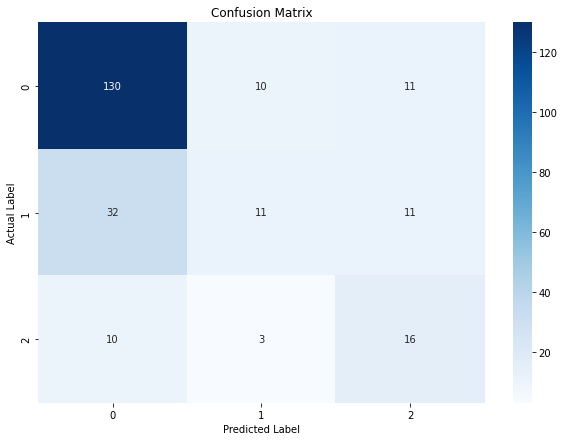

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
probabilities = torch.softmax(torch.tensor(test_results.predictions).to(torch.float32), dim=-1)
predictions = np.argmax(probabilities.numpy(), axis=1)
true_labels = test_results.label_ids
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

In [21]:
import pandas as pd
data_to_save = []
for idx in range(len(test_data)):
    item = dataset['test'][idx]
    actual_label = item['label']
    predicted_label = predictions[idx]
    claim = item['claim'] 
    premise = item['premise'] 
    category = item['category']
    
    # Append the information as a dictionary to the list
    data_to_save.append({
        'Claim': claim,
        'Premise': premise,
        'Actual Label': actual_label,
        'Predicted Label': predicted_label,
        'Category' : category
    })

df = pd.DataFrame(data_to_save)

# Save the DataFrame to a CSV file
df.to_csv('/home/elson/results/2.2.1_results.csv', index=False)

In [22]:
# Calculate correctly classified instances
correctly_classified = df[df['Actual Label'] == df['Predicted Label']]

# Calculate misclassified instances
misclassified = df[df['Actual Label'] != df['Predicted Label']]

# Count the number of correctly classified and misclassified by category
correct_classification_counts = correctly_classified['Category'].value_counts()
misclassification_counts = misclassified['Category'].value_counts()

In [23]:
correct_classification_counts

General Health           35
Bone health              13
Diabetes                 11
Cancer                   11
Cardiovascular Health    10
Fitness                  10
Neurological health       9
Throat                    9
Skin                      7
Hair                      6
COVID                     6
Ear                       6
Men's health              5
Blood                     5
Eye                       4
Women' s Health           4
Mental Health             2
Dental Health             2
Muscles                   2
Name: Category, dtype: int64

In [24]:
misclassification_counts

Skin                     17
General Health           16
Bone health               8
Hair                      6
Fitness                   5
Eye                       5
Muscles                   4
Blood                     4
Vascular                  3
Cardiovascular Health     2
Women' s Health           2
Diabetes                  1
Men's health              1
Dental Health             1
Mental Health             1
Cancer                    1
Name: Category, dtype: int64